# Process Control Project Simulations

## Boilerplate

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint

## Dr. Hedengren's Draft (GEKKO, AI)

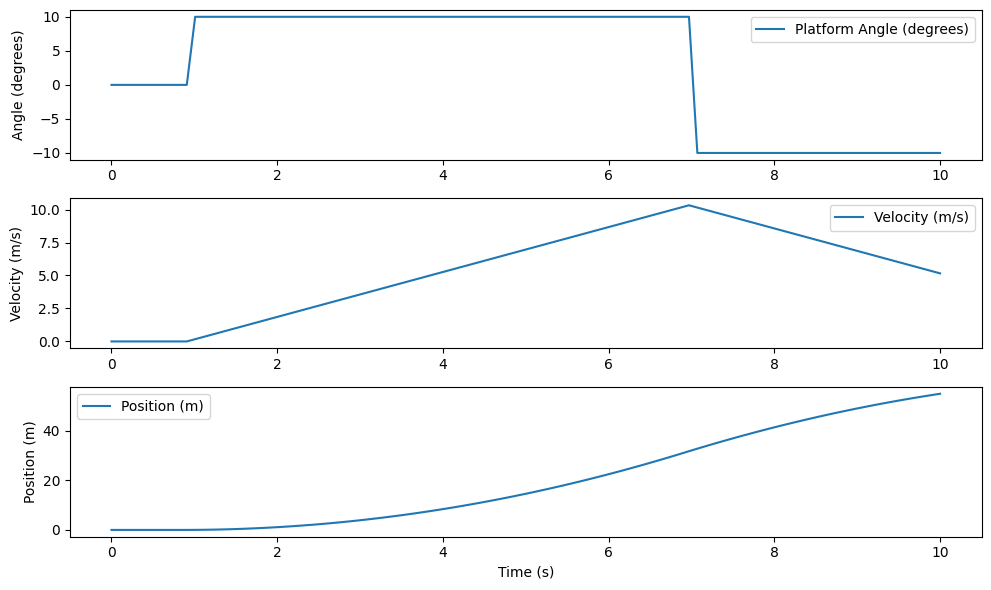

In [10]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

# Initialize Gekko Model
m = GEKKO(remote=False)

# Time horizon
m.time = np.linspace(0, 10, 100)  # 0 to 10 seconds, 100 points

# Parameters and Variables
theta = m.Param(value=0)  # Platform angle (degrees)
g = 9.81                  # Gravity (m/s^2)
x = m.Var(value=0)        # Position of the ball (m)
v = m.Var(value=0)        # Velocity of the ball (m/s)
a = m.Var(value=0)        # Acceleration of the ball (m/s^2)

# Equations of motion
m.Equation(a == g * m.sin(theta * np.pi / 180))  # Convert angle to radians
m.Equation(v.dt() == a)  # Velocity is the derivative of position
m.Equation(x.dt() == v)  # Position is the integral of velocity

# Simulate angle changes (e.g., sinusoidal variation)
angle_profile = 10 * np.sin(m.time * np.pi / 5)  # Varies between ±10 degrees
angle_profile = np.zeros(m.time.shape)
angle_profile[10:] = 10
angle_profile[70:] = -10
theta.value = angle_profile

# Set simulation mode
m.options.IMODE = 4  # Dynamic simulation

# Solve the model
m.solve(disp=False)

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(m.time, theta.value, label='Platform Angle (degrees)')
plt.ylabel('Angle (degrees)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(m.time, v.value, label='Velocity (m/s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(m.time, x.value, label='Position (m)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

plt.tight_layout()
plt.show()

## Open Loop

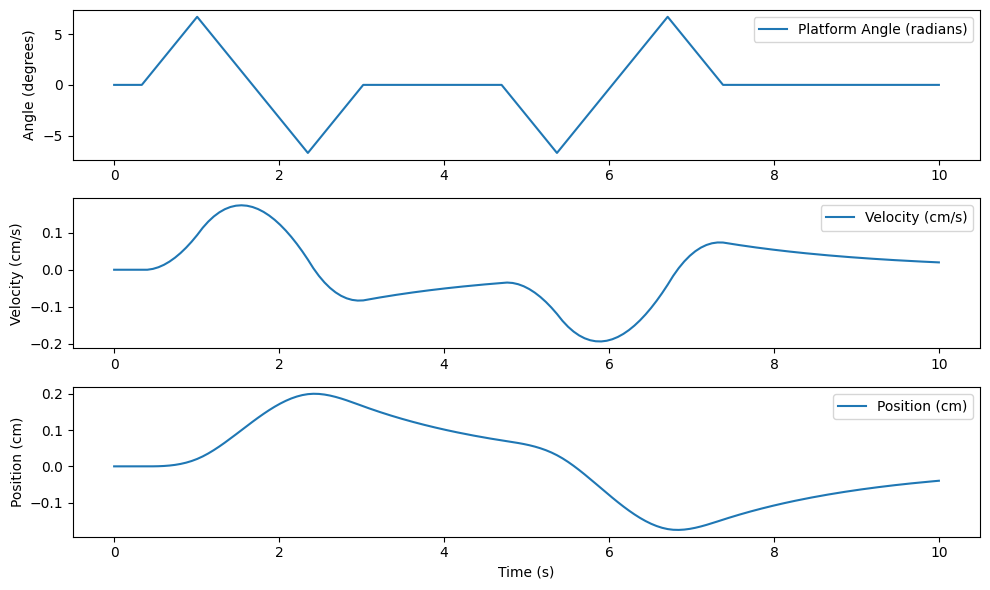

In [59]:
# Process Parameters
maxTime = 10
nPts = 150
m = 3/1000 # kg
g = 9.81 # m/s^2
b = 1.5e-3 # Ns/m (damping coefficient)

# Process Variable Arrays
times = np.linspace(0, maxTime, nPts)
dTheta = np.zeros(len(times)) # deg/s
theta = np.zeros(len(times))  # deg
pos = np.zeros(len(times))
vel = np.zeros(len(times))

# Set changes
maxDTheta = 10    # deg/s
dTheta[5:] = maxDTheta
dTheta[15:] = -maxDTheta
dTheta[35:] = maxDTheta
dTheta[45:] = 0
dTheta[70:] = -maxDTheta
dTheta[80:] = maxDTheta
dTheta[100:] = -maxDTheta
dTheta[110:] = 0

# Lever differential equation
def lever(state, t):
    thetaVal, dThetaVal = state
    return dThetaVal, 0

# Ball differential equation
def ball(state, t, thetaVal):
    x, dx = state
    return dx, m*g*np.sin(thetaVal) - b*dx/m

# Simulate
for i in range(len(times)-1):
    tArr = [times[i], times[i+1]]
    # First, integrate for new lever position
    init = [theta[i], dTheta[i]]
    theta[i+1] = odeint(lever, init, tArr)[-1][0]
    # Next, integrate for ball position
    init = [pos[i], vel[i]]
    result = odeint(ball, init, tArr, args=(theta[i]/180*np.pi,))
    pos[i+1], vel[i+1] = result[-1]

# Plot results
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(times, theta, label='Platform Angle (radians)')
plt.ylabel('Angle (degrees)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(times, vel*100, label='Velocity (cm/s)')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(times, pos*100, label='Position (cm)')
plt.ylabel('Position (cm)')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()

## Closed Loop

In [ ]:
Kc = 
tauI = 
tauD = 
def pid(sp,pv,pv_last,ierr,dt):
    """
    ------------------------
    PID Controller Function
    ------------------------
    Inputs:
        sp = setpoint
        pv = current temperature
        pv_last = prior temperature
        ierr = integral error
        dt = time increment between measurements
    Outputs:
        op = output of the PID controller
        P = proportional contribution
        I = integral contribution
        D = derivative contribution
    """
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]